# Generation of hypothesis on regulons / pathways and processes linked to single cell -omics data

- **One line summary of the chapter**

Describing a general example on how to generate a Gene Regulatory Network, using general bioinformatics tools.

- **Here, plus steps of the chapter**

    - Installing SCENIC
    - Executing SCENIC using the NeurIPS 2021 dataset.
    - Interpreting the results from SCENIC

- **Outocome of the analysis. What things can be done with these outputs.**

    - Interpreting single cell RNA-seq data based on potential transcription factors regulating cell states and/or transitions.

## What is a regulon
- **Definition of a TF-regulon**

A regulon is a set of target genes that **regu**lated by a particular factor. In the context of gene regulation, a TF-regulon is a set of genes that is regulated by the activity of a transcription factor (TF).

## How we can get a regulon

TF- Regulons have been annotated in academic studies, databases that compiled those, and also consortia efforts such as ENCODE. Among general references, one can inspect [TTRUST](https://www.grnpedia.org/trrust/), [DoRothEA](https://saezlab.github.io/dorothea/), [KnockTF](http://www.licpathway.net/KnockTFv2/index.php), among others, for eukaryotic TF-regulons. For prokaryotes [RegulonDB](https://regulondb.ccg.unam.mx/) is a well maintained database.

- **Does it work in all scenarios?**

The source and confidence of a TF-regulon has some limitations, such as data source and experimental readout. If the data source for a regulon is not matched to the cell type of interest, then results can not be put into the context of the particular biological system. If the experimental readout is not measuring *cis* regulation events, directly provoked by the TF of interest, our TF-regulon might contain *trans* regulation events.

- **What considerations should be taken for running this regulon-based analysis?**

The usage of a TF-regulon gather in an equivalent biological system is recommended. However, the interpretation of results might be biased due to forcing of priors.


**In this notebook we will summarize and use two approaches for this purpose, and highlight caveats that can occur during the analyses of the data, at every possible step, wheverer possible.**

- As a dataset, we will use
    - Cell-type clusters of 100,000 human PBMCs and the NeurIPS dataset, which contain healthy donors as well as COVID-19 patients{cite}`Schulte-Schrepping2020`.

### Installation of SCENIC

In [1]:
# conda create -y -n pyscenic python=3.7
# conda activate pyscenic
# conda install -y numpy
# conda install -y -c anaconda cytoolz

# pip install pyscenic

# other libraries necessary for installation
# pip install scanpy
# pip install pyscenic

## Environment setup

In [2]:
import warnings


# here verify all the relevant import that will be required.
warnings.filterwarnings("ignore")

import pyscenic
import loompy as lp

import scanpy as sc
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import os
# import matplotlib.pyplot as plt
# import seaborn as sns
# import scanpy as sc
# import pandas as pd
# import numpy as np
# import random

# import rpy2.rinterface_lib.callbacks
# import anndata2ri
# import logging

# from rpy2.robjects import pandas2ri
# from rpy2.robjects import r

# sc.settings.verbosity = 0
# rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# pandas2ri.activate()
# anndata2ri.activate()

# %load_ext rpy2.ipython

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
# R imports that will be required.
# %%R
# library(edgeR)
# library(MAST)

## Preprocessing of the NeurIPs dataset

The current dataset we will be looking here is already pre-processed (previous chapters), and it contains:

- X cells, classified into N sub-types.
- More details on subpopulations and others.

First, we load the full dataset.

In [3]:
adata = sc.read_h5ad('../../data/openproblems_bmmc_multiome_genes_filtered.h5ad')
adata.shape

### We will only use features that are linked to RNA features (i.e. genes, and not ATAC-seq peaks)

In [5]:
rna = adata[:,adata.var.feature_types == 'GEX']
sc.pp.log1p(rna)
rna.obs.batch.value_counts()

s4d8     9876
s4d1     8023
s3d10    6781
s1d2     6740
s1d1     6224
s2d4     6111
s2d5     4895
s3d3     4325
s4d9     4325
s1d3     4279
s2d1     4220
s3d7     1771
s3d6     1679
Name: batch, dtype: int64

In [6]:
rna.shape

(69249, 13431)

## The selection of highly variable genes minimizes the number of processing steps down-stream. An execution without defining HVGs is also possible

In [7]:
sc.pp.highly_variable_genes(rna, batch_key='batch', flavor='seurat')

In [8]:
rna.shape

(69249, 13431)

In [9]:
sc.set_figure_params(facecolor='white')

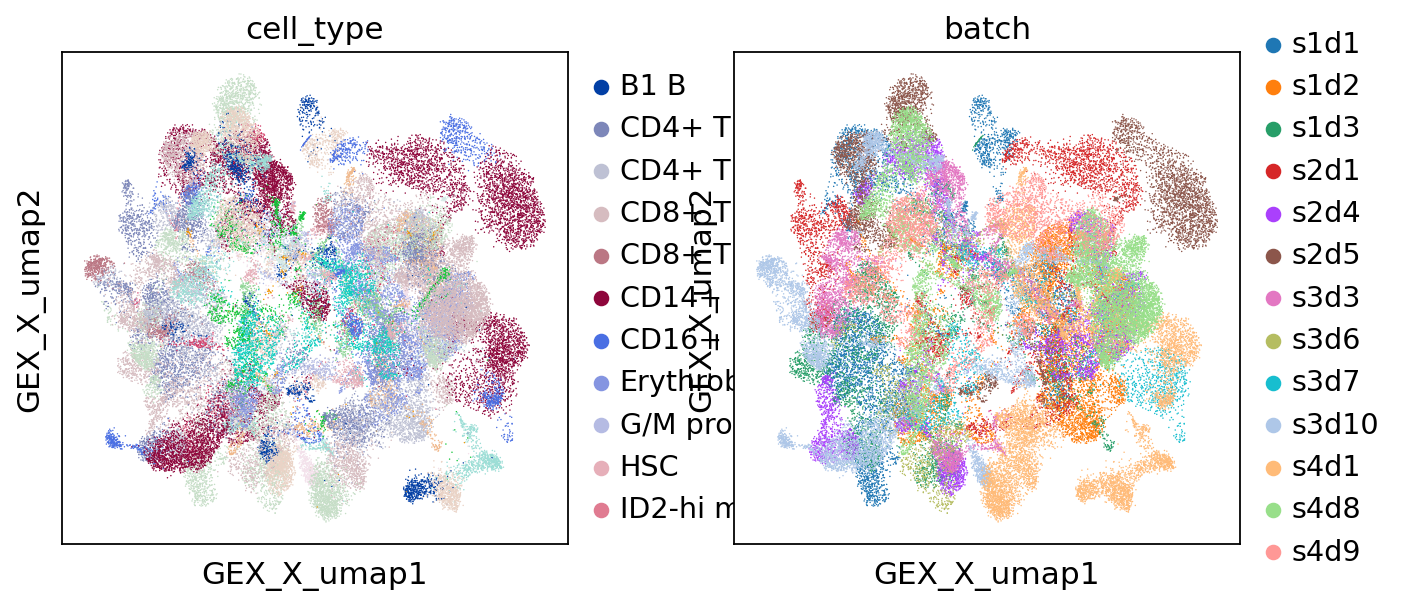

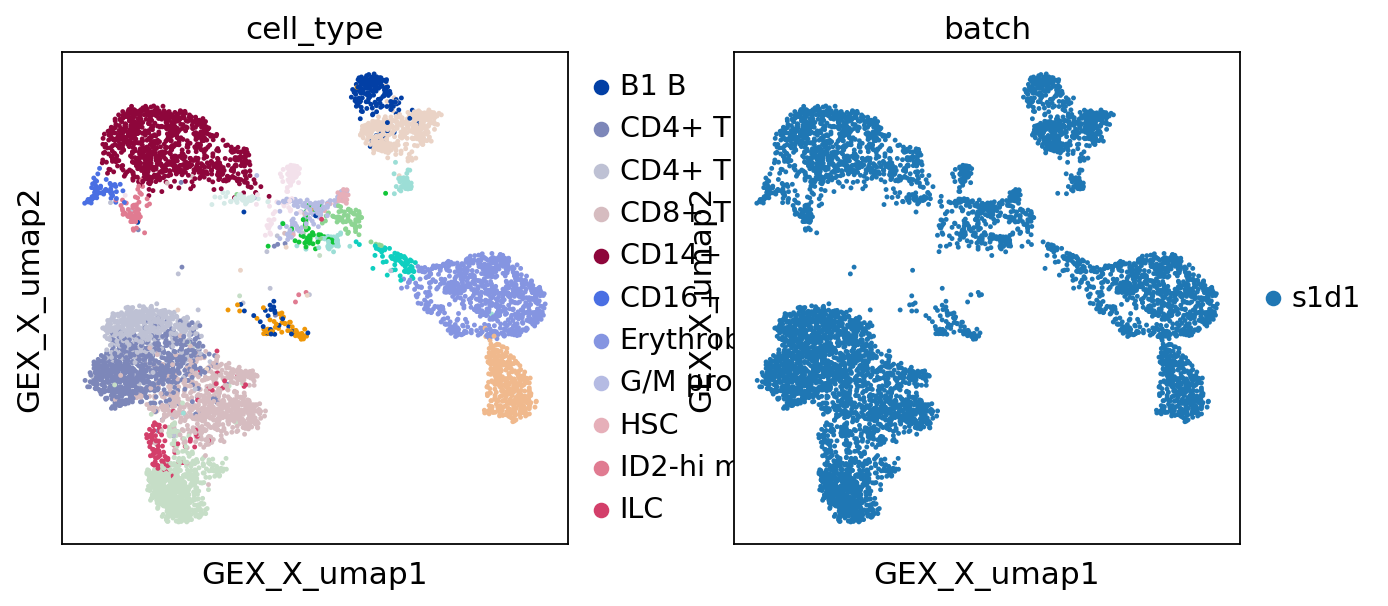

In [29]:
print('all data')
sc.pl.embedding(rna, 'GEX_X_umap', color=['cell_type','batch'])

In [ ]:
adata_batch = rna[rna.obs.batch == 's1d1',:] 
print('custom batch (input')
sc.pl.embedding(adata_batch, 'GEX_X_umap', color=['cell_type','batch'])

### To execute SCENIC, we define the input based on the dataset we have in place, and write the input file using loompy

In [30]:
# !wget https://raw.githubusercontent.com/aertslab/SCENICprotocol/master/example/allTFs_hg38.txt
tfs_path = 'allTFs_hg38.txt' 

In [31]:
loom_path = 'data/neurips_processed_input.loom'
loom_path_output = 'data/neurips_processed_output.loom'

tfs = [tf.strip() for tf in open(tfs_path)]
len(tfs)
# adata.var.index
# set(adata.var.index).intersection(set(tfs))

1797

### Step recommendation: Check that most of your TFs are part of the provided object

In [40]:
# as a general QC. We inspect that our object has transcription factors listed in our main annotations.
print(np.sum(adata_batch.var.index.isin(tfs)), 'out of', len(tfs), 'TFs are found in the object')

1160 out of 1797 TFs are found in the object


In [32]:
use_hvg = True
if use_hvg:
    mask = (adata_batch.var['highly_variable'] == True) | adata_batch.var.index.isin(tfs)
    adata_batch = adata_batch[:,mask]

### Create a loom file for NeurIPS donor
- Note: the labels for Gene/CellID/etc. cannot be arbitrarily redefined, as then

In [41]:
row_attributes = { 
    "Gene": np.array(adata_batch.var.index) ,
}
col_attributes = { 
    "CellID":  np.array(adata_batch.obs.index) ,
    "nGene": np.array( np.sum(adata_batch.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata_batch.X.transpose() , axis=0)).flatten() ,
}

lp.create(loom_path, adata_batch.X.transpose(), row_attributes, col_attributes )

In [42]:
adata_batch.shape

(6224, 2785)

In [ ]:
outpath_adj = 'adj.csv'

In [ ]:
if not os.path.exists(outpath_adj):
    !pyscenic grn {loom_path} {tfs_path} -o $outpath_adj --num_workers 3

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

2022-08-03 14:55:24,528 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-08-03 14:55:25,551 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/extended-single-cell-best-practices/jupyter-book/mechanisms/dask-worker-space/worker-8rk6uerp', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/extended-single-cell-best-practices/jupyter-book/mechanisms/dask-worker-space/worker-8uq

The output of this analysis is a set of associations between genes, inferred by GRNBoost, and summarized by a directional weight between TFs and target genes.

In [34]:
results_adjacencies = pd.read_csv("adj.csv", index_col=False, sep=',')

EmptyDataError: No columns to parse from file

In [58]:
results_adjacencies

,TF,target,importance
0,KLRG1,CCL5,1.302114e+02
1,CEBPB,CST3,1.209252e+02
2,CEBPB,AIF1,1.124120e+02
3,SPIB,CD79A,1.115563e+02
4,CEBPB,FCER1G,1.105480e+02
...,...,...,...
154403,PLAGL2,ZNF256,8.065555e-12
154404,SRP9,MALT1,3.394097e-12
154405,ZNF397,PRAF2,4.094659e-13
154406,JAZF1,TDG,3.413799e-13


(-10.0, 10.0)

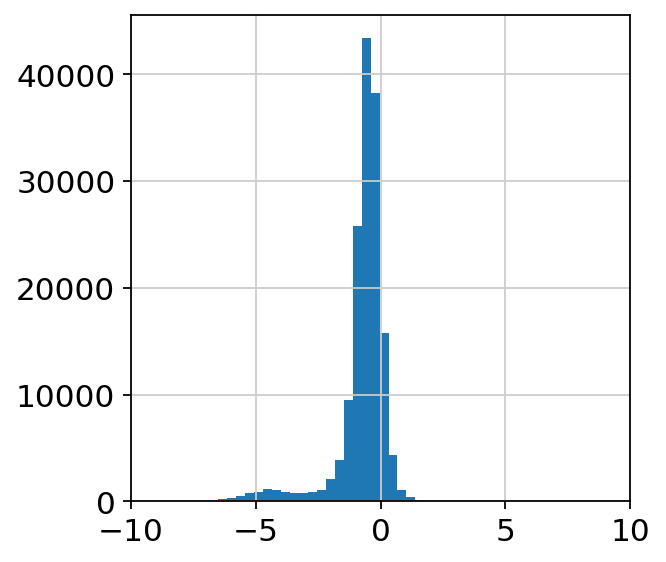

In [64]:
plt.hist(np.log10(results_adjacencies['importance']), bins=50)
plt.xlim([-10, 10])

In [69]:
# !wget https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather

--2022-06-01 14:18:25--  https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather
Resolving resources.aertslab.org (resources.aertslab.org)... 134.58.65.132
Connecting to resources.aertslab.org (resources.aertslab.org)|134.58.65.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1327758248 (1.2G)
Saving to: ‘hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather’

hg38__refseq-r80__1 100%[===================>]   1.24G  2.61MB/s    in 8m 20s  

2022-06-01 14:26:45 (2.53 MB/s) - ‘hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather’ saved [1327758248/1327758248]



In [70]:
import glob
# ranking databases
db_glob = "*feather"
db_names = ' '.join( glob.glob(db_glob) )



### Motif databases

- Here we use the archetypes definition of motifs, genome wide, to refine our associations between TFs and genes

In [65]:
# !wget https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl

--2022-06-01 14:14:14--  https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl
Resolving resources.aertslab.org (resources.aertslab.org)... 134.58.65.132
Connecting to resources.aertslab.org (resources.aertslab.org)|134.58.65.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103568514 (99M)
Saving to: ‘motifs-v9-nr.hgnc-m0.001-o0.0.tbl’

motifs-v9-nr.hgnc-m 100%[===================>]  98.77M  2.33MB/s    in 41s     

2022-06-01 14:14:55 (2.42 MB/s) - ‘motifs-v9-nr.hgnc-m0.001-o0.0.tbl’ saved [103568514/103568514]



In [68]:
# motif databases
motif_path = "motifs-v9-nr.hgnc-m0.001-o0.0.tbl"
assert os.path.exists(motif_path)

This step can take ~8 minutes in a laptop.

In [76]:
!pyscenic ctx adj.csv \
    {db_names} \
    --annotations_fname {motif_path} \
    --expression_mtx_fname {loom_path} \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 20

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

2022-06-01 14:28:38,627 - pyscenic.cli.pyscenic - INFO - Creating modules.

2022-06-01 14:28:38,713 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-06-01 14:28:39,141 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-06-01 14:28:39,162 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2022-06-01 14:28:40,059 

Threshold for selection of best number of TFs
- Rule of thumb is to explore different thresholds visually, to obtain a high signal-to-noise ratio

custom quantiles for further exploration

In [79]:
nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)
percentiles = pd.Series(nGenesDetectedPerCell).quantile([.01, .05, .10, .50, 1])
print(percentiles)

0.01     98.0
0.05    112.0
0.10    121.0
0.50    156.0
1.00    590.0
dtype: float64


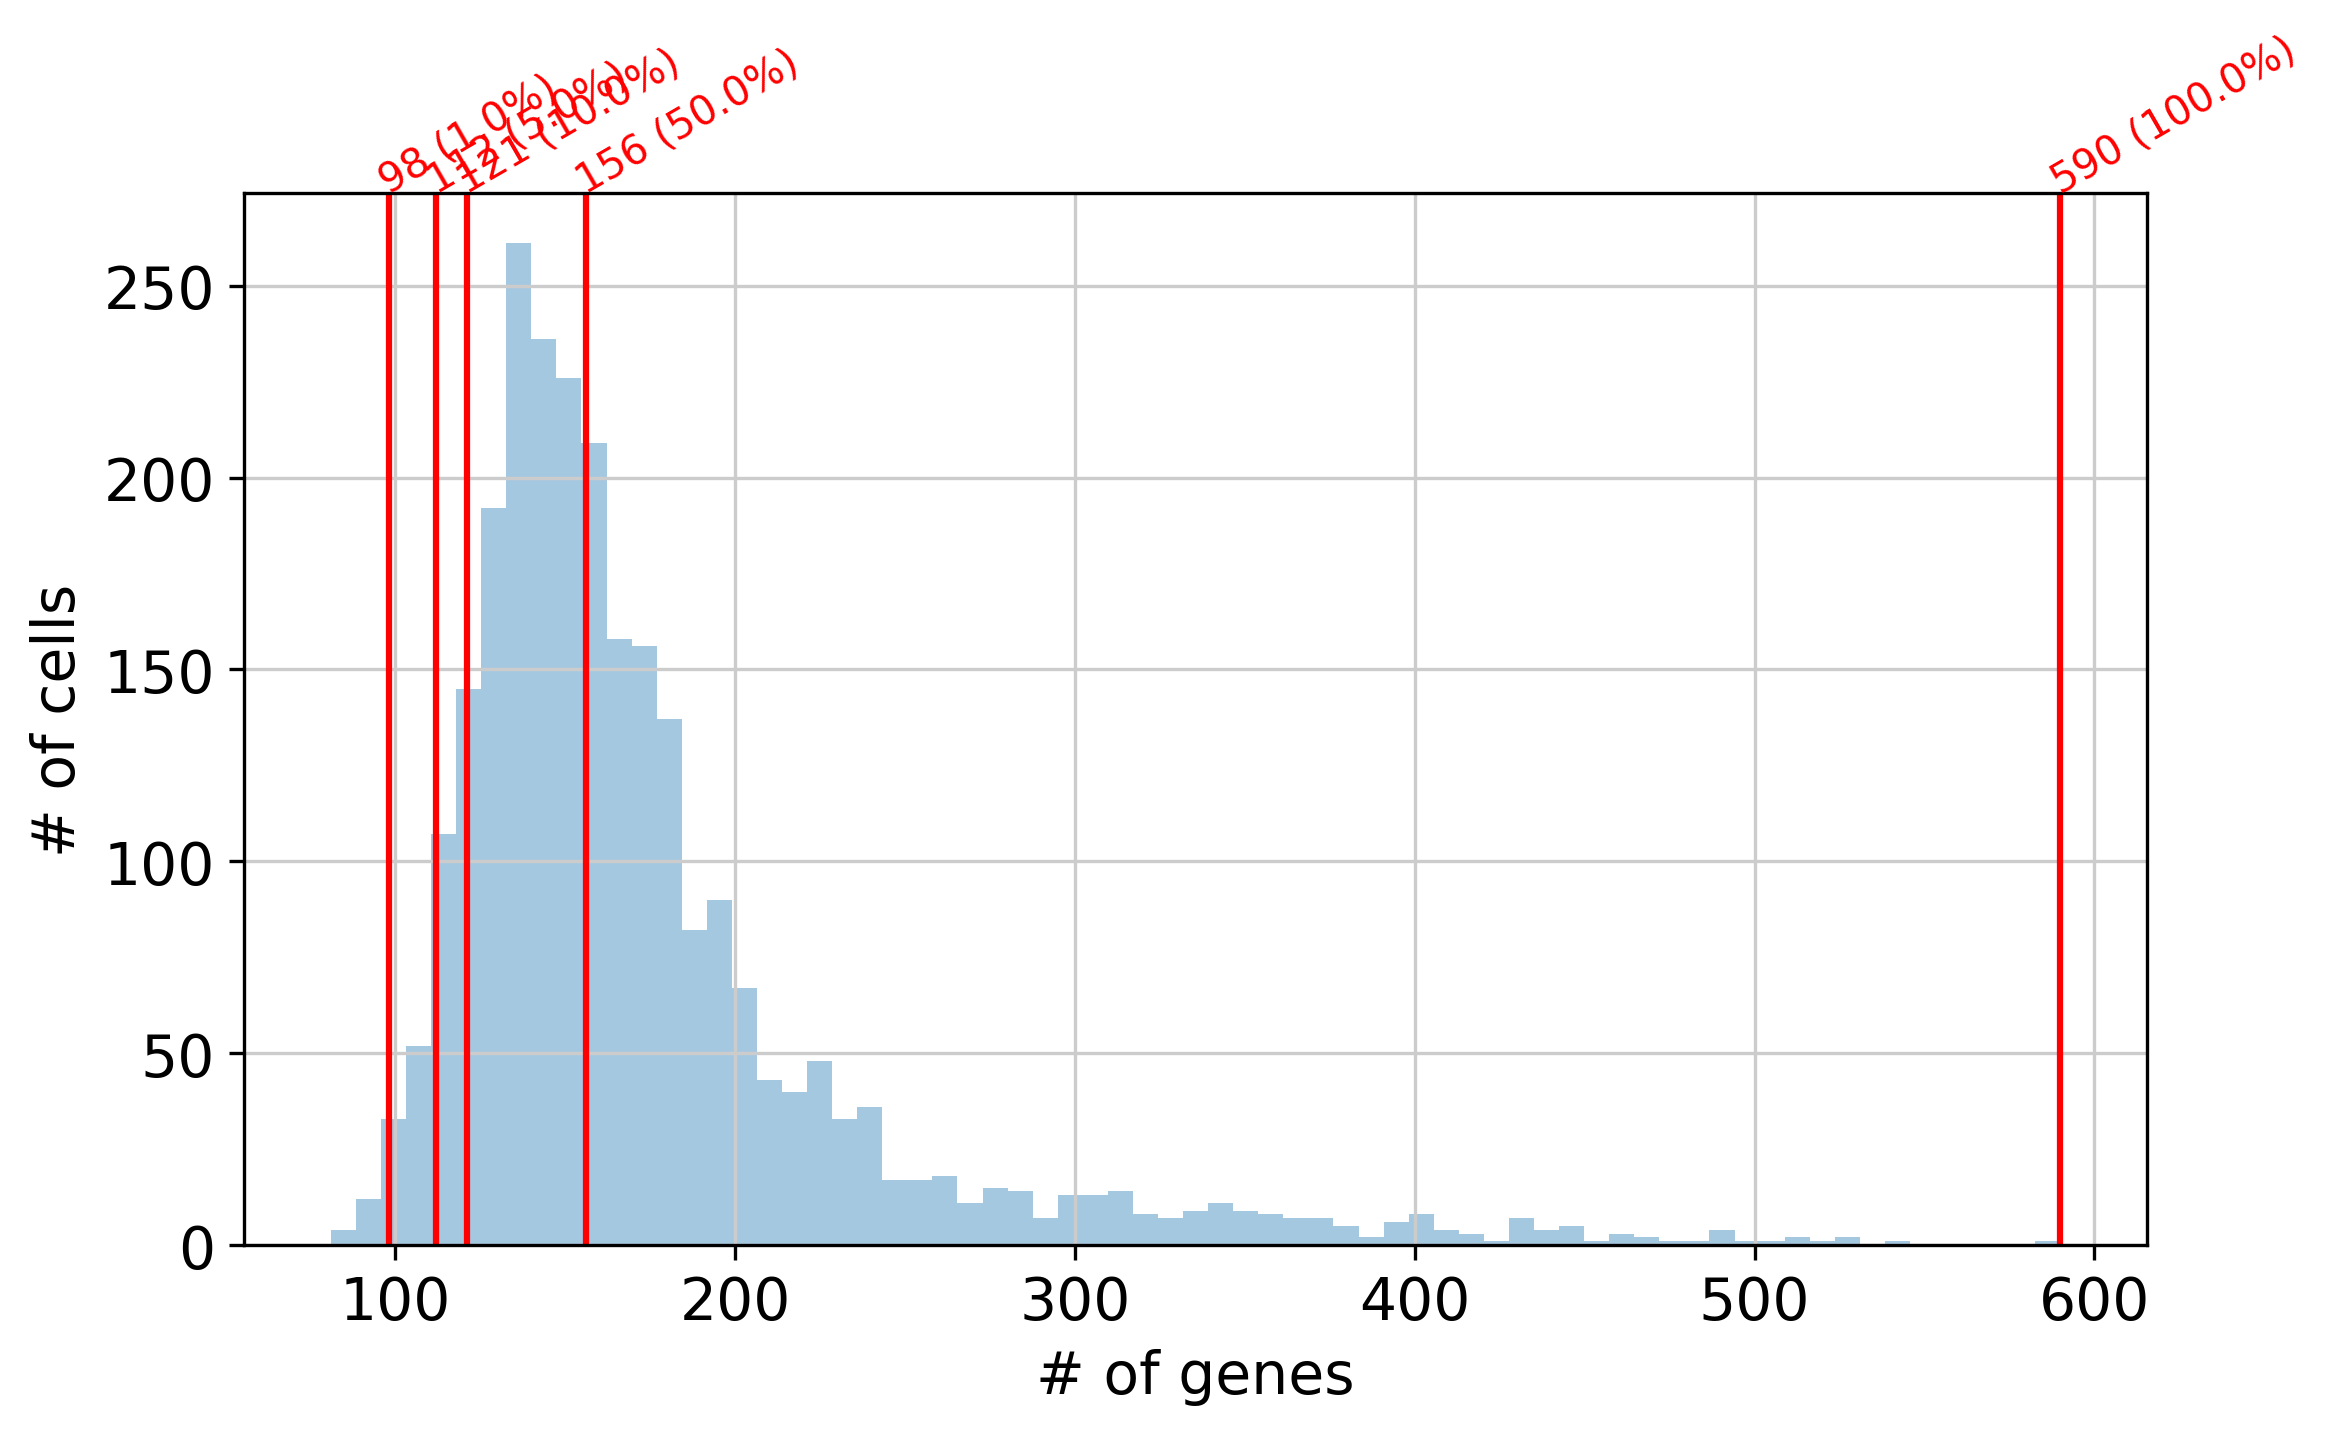

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [94]:
!ls -ltrh $loom_path

-rwxrwxrwx 1 rio rio 17M Jun  1 13:32 data/pbmc3k_processed.loom


In [95]:
loom_path

'data/pbmc3k_processed.loom'

In [97]:
os.path(loom_path)

TypeError: 'module' object is not callable

In [98]:
!pyscenic aucell $loom_path \
    reg.csv \
    --output {loom_path_output} \
    --num_workers 20

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
usage: pyscenic aucell [-h] [-o OUTPUT] [-t] [-w] [--num_workers NUM_WORKERS]
                       [--seed SEED] [--rank_threshold RANK_THRESHOLD]
                       [--auc_threshold AUC_THRESHOLD]
                       [--nes_threshold NES_THRESHOLD]
                       [--cell_id_attribute CELL_ID_ATTRIBUTE]
                       [--gene_attribute GENE_ATTRIBUTE] [--sparse]
                       expression_mtx_fname signatures_fname
pyscenic aucell: error: the following arguments are required: signatures_fname


In [84]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

NameError: name 'pyscenic_output' is not defined

### **Bookmark for current work stopped**

## We will be working with batch-corrected normalized counts, to correct patient/batch effects.

In [ ]:
np.max(adata.X)

49066.0

In [ ]:
adata.layers["counts"] = adata.X.copy()

In [ ]:
# # Afterwards, we need to subset the full data to our conditions of interest. We also create cleaner metadata names. -->
# adata.obs["condition"] = adata.obs["group_per_sample"].copy()
# adata.obs["cell_identity"] = adata.obs["hemato.labels"].copy()

In [1]:
# #adata = adata[adata.obs["condition"].isin(["control", "severe"])]
# adata

<!-- We also restrict our control samples to one study (Reyes et al., Nat Med, 2020) -->

In [2]:
# adata = adata[
#     ~(
#         (adata.obs["condition"] == "control")
#         & (adata.obs["experiment"] != "Reyes et al., Nat Med, 2020")
#     )
# ]

<!-- After subsetting, we have 19 control and 10 disease patients. -->

In [ ]:
len(adata[adata.obs["condition"] == "control"].obs["donor"].cat.categories)

19

We filter cells which have less than 200 genes and genes which were found in less than 3 cells for a rudimentary quality control.

In [3]:
# sc.pp.filter_cells(adata, min_genes=200)
# sc.pp.filter_genes(adata, min_cells=3)
# adata

## SCENIC

SCENIC is a method in R initially developed for ... It implements .... as provided by **method types**
For more details please read the original references publication{cite}`Robinson2010`.

Here, we will be using the the particular modality of SCENIC that accounts for .... . In contrast, variants of this processing can result in sligthly different results. Additionally, one should carefully assess different parameters for analyses, in order to generate sparser of broader associations between TFs and regulons..

We first
- Recipe step one. For each patient we create X clusters.
- We **step-two**.
- We **step-three**

The final output of our analysis will be a set of associations between TF-regulons, quantified by a p-value based on significance. We strongly recommend refer to **REF** for more information about interpretation of these associations.

First, we repeat the filtering step for each condition separately.

In [4]:
# severe = adata[adata.obs["condition"] == "severe"].copy()
# control = adata[adata.obs["condition"] == "control"].copy()
# severe, control

**Step one**

In [5]:
# sc.pp.filter_genes(severe, min_cells=3)
# severe

In [6]:
# sc.pp.filter_genes(control, min_cells=3)
# control

**Step two**

In [8]:
# adata_pp = severe.concatenate(control, index_unique=None)
# # adata_pp

<!-- Now, let's define the function we need to aggregate single cells into pseudo-replicates:
- `aggregate_and_filter` is a function that creates an AnnData object with 3 pseudo-replicates for each donor for a specified subpopulation from the original single-cell AnnData object. Here we also filter out donors that have fewer than 30 cells for the specified population. -->

aggregation of function per donor.

In [9]:
# NUM_OF_CELL_PER_DONOR = 30


# def aggregate_and_filter(
#     adata,
#     cell_identity,
#     donor_key="donor",
#     condition_key="condition",
#     cell_identity_key="cell_identity",
#     obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
#     replicates_per_patient=3,
# ):
#     # subset adata to the given cell identity
#     adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
#     # re-filter for this cell population
#     sc.pp.filter_genes(adata_cell_pop, min_cells=3)
#     # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
#     size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
#     donors_to_drop = [
#         donor
#         for donor in size_by_donor.index
#         if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
#     ]
#     df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

#     adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
#     for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
#         print(f"Processing donor {i+1} out of {len(donors)}...", end="\r")
#         if donor not in donors_to_drop:
#             adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
#             # create replicates for each donor
#             indices = list(adata_donor.obs_names)
#             random.shuffle(indices)
#             indices = np.array_split(np.array(indices), replicates_per_patient)
#             for i, rep_idx in enumerate(indices):
#                 adata_replicate = adata_donor[rep_idx]
#                 # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
#                 agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
#                 for obs in obs_to_keep:
#                     agg_dict[obs] = "first"
#                 # create a df with all genes, donor and condition info
#                 df_donor = pd.DataFrame(adata_replicate.X.A)
#                 df_donor.index = adata_replicate.obs_names
#                 df_donor.columns = adata_replicate.var_names
#                 df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
#                 # aggregate
#                 df_donor = df_donor.groupby(donor_key).agg(agg_dict)
#                 df_donor[donor_key] = donor
#                 df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]

#     # create AnnData object from the df
#     adata_cell_pop = sc.AnnData(
#         df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
#     )
#     return adata_cell_pop

Metadata info into object # We might want to look at available metadata later and therefore keep it in the AnnData object.

In [ ]:
# obs_to_keep = [
#     "donor",
#     "condition",
#     "cell_identity",
#     "platform",
#     "purification",
#     "cells",
#     "age",
#     "sex",
#     "who_per_sample",
#     "disease_stage",
#     "outcome",
# ]

We need to pass the raw counts to edgeR. Hence, we set `.X` to the `counts` layer to ensure the pseudo-replicates are created for raw counts.

In [ ]:
# adata.X = adata.layers["counts"].copy()

Running analysis on X cell type

In [12]:
# %%time
# adata_gran = aggregate_and_filter(adata_pp, "Granulocytes", obs_to_keep=obs_to_keep)
# adata_gran

** - The validy of this analysis depends highly on ... **

** - Inflating the number of TF-gene associations can saturate the regulon information.**

** - Permutations/subsampling can be used to asses the robustness of the analysis.**

We perform very basic EDA on the created pseudo-replicates to check if some patients/pseudobulks are outliers that we need to exclude not to bias the DE results.

In [ ]:
# sc.pp.pca(adata_gran)

In [ ]:
# # set categorical metadata to be indeed categorical
# adata_gran.obs["donor"] = adata_gran.obs["donor"].astype("category")
# adata_gran.obs["condition"] = adata_gran.obs["condition"].astype("category")

<!-- Next, we look at created pseudo-replicates on a PCA plot and color by all the available metadata to see if there are any confounding factors that we might want to include in the design matrix.  -->

In [13]:
# sc.pl.pca(adata_gran, color=adata_gran.obs, ncols=1, size=300, legend_loc="on data")

- Outlier..

- Additionally, PC1 is confounded by ....

In [14]:
# # exclude outliers
# adata_gran = adata_gran[~adata_gran.obs["donor"].isin(["C19-CB-0009", "C19-CB-0008"])]
# adata_gran

- Running pipeline X
- The function - `name of function` takes X and does Y. Results R

In [15]:
# %%R
# find_de_edgeR <- function(adata_){
#     # create an edgeR object with counts and grouping factor
#     y <- DGEList(assay(adata_, "X"), group = colData(adata_)$condition)
#     # filter out genes with low counts
#     print("Dimensions before subsetting:")
#     print(dim(y))
#     print("")
#     keep <- filterByExpr(y)
#     y <- y[keep, , keep.lib.sizes=FALSE]
#     print("Dimensions after subsetting:")
#     print(dim(y))
#     print("")
#     y <- calcNormFactors(y)
#     # create a design matrix: here we have multiple donors so also consider that in the design matrix
#     design <- model.matrix(~ colData(adata_)$condition + colData(adata_)$donor)
#     # when we have both condition and donor information in the design matrix, it becomes not full rank
#     # i.e. sum over condition columns minus sum over donor columns = 0
#     # so we remove the last column so the matrix has full rank again
#     design <- design[,-ncol(design)]
#     print("Head of the design matrix after removing the last column:")
#     print(head(design))
#     print("")
#     y <- estimateDisp(y, design = design)
#     fit <- glmQLFit(y, design)
#     # here we have two conditions and interested in differences between them, so look at the corresponding coefficient
#     qlf <- glmQLFTest(fit, coef=2)
#     # get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
#     tt <- topTags(qlf, n = Inf)
#     print("Head of the table with the test results:")
#     print(head(tt))
#     counts = data.matrix(tt$table)
#     res = SingleCellExperiment(assays = list(counts = counts))
    
#     return(list("sc" = as(res, 'SingleCellExperiment'), "y" = y, "tt" = tt, "qlf" = qlf, "design" = design))
# }

In [16]:
# %%time
# %%R -i adata_gran -o outputs
# outputs < -find_de_edgeR(adata_gran)

In [ ]:
# %%R -o res_gran
# res_gran <- outputs$sc
# y <- outputs$y
# tt <- outputs$tt
# qlf <- outputs$qlf
# design <- outputs$design

Additionally, one could also test for X category e.g. DE-genes.

In [17]:
# %%R
# fit <- glmQLFit(y, design)
# tr <- glmTreat(fit, coef=2, lfc=1.5)
# print(head(topTags(tr)))

Having a result, we can observe the number of significant associations found, stratified by effect size.

In [18]:
# %%R
# plotMDS(y)

- Value X indicates Y.


- sparse TF-gene interactions might be harder to associate with gene.

- Metric Y is X.  

- In the plot below, we can see that ....

In [19]:
# %%R
# plotBCV(y)

- All in all, we can see that X genes have a equal or lower than Y.

- A **visualization plot** shows the effect size as a function of Y. This can be used to assess the presence of systematic biases in the data.

In [20]:
# %%R
# plotSmear(qlf, de.tags = rownames(tt$table)[which(tt$table$FDR<0.01)])

We can repeat this analysis on a cluster specific way

In [21]:
# %%time
# adata_mono = aggregate_and_filter(adata_pp, "Monocytes", obs_to_keep=obs_to_keep)
# adata_mono

We repeat basic EDA.

In [22]:
# sc.pp.pca(adata_mono)

# adata_mono.obs["donor"] = adata_mono.obs["donor"].astype("category")
# adata_mono.obs["condition"] = adata_mono.obs["condition"].astype("category")

# sc.pl.pca(adata_mono, color=adata_mono.obs, ncols=1, size=300, legend_loc="on data")

Comment on the provided visualization

In [24]:
# %%time
# %%R -i adata_mono -o outputs
# outputs < -find_de_edgeR(adata_mono)

In [ ]:
# %%R -o res_mono
# res_mono <- outputs$sc
# y <- outputs$y
# tt <- outputs$tt
# qlf <- outputs$qlf

This plot can be able to identify cluster-specific TF-regulons

In [25]:
# %%R
# plotMDS(y)

<!-- We see some low abundace genes with high bcv here. We can label those genes, but there should not be any concerns here. -->

In [26]:
# %%R
# plotBCV(y)

In [27]:
# %%R
# plotSmear(qlf, de.tags = rownames(tt$table)[which(tt$table$FDR<0.01)])

<!-- From these plots we can see that compared to granulocytes, we obtained a higher number of DE genes for monocytes. -->

<!-- We can additionally visualize results with a heatmap and a volcano plot. Each row of a heatmap corresponds to a gene and each column to a single-cell. The brighter the color is the higher is the expresion of that gene in a particular cell. Since we only plot DE genes, we would like to see clear differences in expression between the two conditions. Volcano plots are often used to visualize results of statistical testing, and they show the change in expression on the x-axis (log-fold change) and statistical significance on the y-axis (FDR-corrected p-values). We color code the genes that have FDR-corrected p-value under 0.01 and log-fold change of over 1.5 -->

<!-- We need to define an additional helper funcion to clean up the results and store it in the original AnnData object. We store the output of the edgeR analysis in `.varm` where data for genes that were not used is set to `np.nan`. -->

In [28]:
# def prep_result(adata_res, adata):
#     result = pd.DataFrame(
#         adata_res.X.T, index=adata_res.var_names, columns=adata_res.obs_names
#     )
#     result = pd.DataFrame(index=adata.var_names).join(result, how="outer")
#     result = result.T[adata.var_names].T
#     return result

In [ ]:
# res_gran

AnnData object with n_obs × n_vars = 5 × 1083

In [ ]:
# res_mono

AnnData object with n_obs × n_vars = 5 × 5461

In [ ]:
FDR = 0.01
LOG_FOLD_CHANGE = 1.5


def plot_heatmap(adata, res, cell_identity):
    res = res[(res["FDR"] < FDR) & (abs(res["logFC"]) > LOG_FOLD_CHANGE)].sort_values(
        by=["logFC"]
    )
    print(f"Plotting {len(res)} genes...")
    markers = list(res.index)
    sc.pl.heatmap(
        adata[adata.obs["cell_identity"] == cell_identity].copy(),
        markers,
        groupby="condition",
        swap_axes=True,
    )

And finally we can plot the heatmaps for granulocytes and monocytes.

Plotting 233 genes...


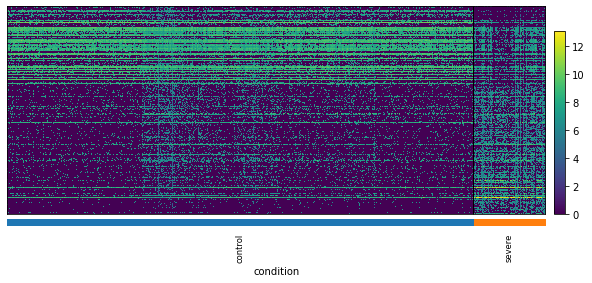

In [ ]:
plot_heatmap(adata_pp, adata_pp.varm["edgeR_granulocytes"], "Granulocytes")

Plotting 662 genes...


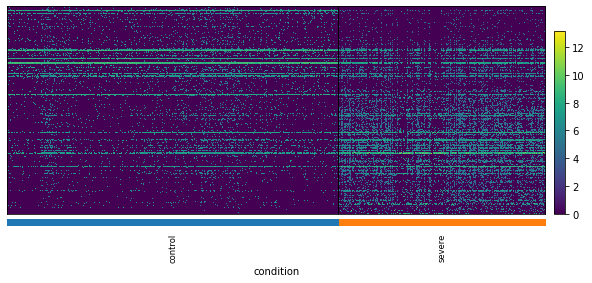

In [ ]:
plot_heatmap(adata_pp, adata_pp.varm["edgeR_monocytes"], "Monocytes")

We can see that the differences in expressions are clearer for granulocytes than for monocytes. Because there are also differences in gene expression within the cell populations (blocks of brighter/darker columns within condition), it probably indicates some substructures in both populations that are not captured but the current cell type annotation which may be interesting to investigate further.

### Notes on SCENIC:
- Requires X counts as input
- Requires labels for categories
- We recommend global and cluster specific differences, in order to tease out patterns associated to specific biological groups.

## Method 2 (ATAC+RNA)

## Key Takeaways

1. Experimental design and analysis
2. Detect global and cluster-specific regulons allows going into types of signal based on how easy and those are to be assessed as significant.
3. Statistical power is increased by generating broad gene groups with at least 100 or more genes per category. Lower gene numbers per group would dissipate the signal, and make the listing of TF-gene associations per cluster more difficult.

## Quiz

1. What is a TF-regulon and in what scenarios it might be worth discovering those?

2. What is the futility theorem? 

3. Are there more motif categories or more transcription factors? How can one reconcile the redundancy of these during the analysis?

4. How can one find cluster specific TF-regulons?

## References